# Gaussian process regression

With explicitly sampled (not marginalized) $f$, to demonstrate elliptical slice sampling.

ToC:

- GP regression
- GP classification
- Heteroskedastic GPs

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '0'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [0]


In [ ]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
import jaxkern as jk

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import sys
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from jaxtyping import Array
from bamojax.base import Node, Model
from bamojax.samplers import gibbs_sampler
from bamojax.more_distributions import GaussianProcessFactory, Zero
from bamojax.inference import SMCInference

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


## The basic GP

Here we showcase Gaussian process regression using bamojax. The model is given by:

$$
\begin{align*}
    \log \ell &\sim \text{Gaussian}(0,1)\\
    \log \tau &\sim \text{Gaussian}(0,1)\\
    \log \sigma &\sim \text{Gaussian}(0, 1)\\
    k(x, x'; \ell, \tau) &= \tau^2 \exp\left(-\frac{(x-x')^2}{2\ell^2}\right) \\
    f &\sim \mathcal{GP}(0, k(x, x'; \ell, \tau)) \\    
    y_i & \sim \text{Gaussian}\left(f(x_i), \sigma^2\right) 
\end{align*}
$$

Simulate observations:

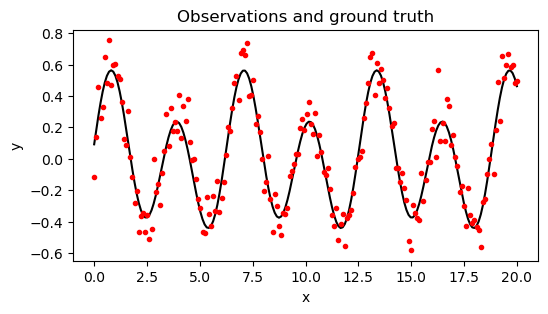

In [4]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

sigma = 0.1
n = 200
x = jnp.linspace(0, 20, n)[:, jnp.newaxis]

f_true = 0.4*jnp.sin(2*x) + 0.1*jnp.cos(x-0.4) + 0.1*jnp.sin(x)
y = f_true.squeeze() + sigma*jrnd.normal(subkey, shape=(n,))

plt.figure(figsize=(6, 3))
plt.plot(x, f_true, color='k')
plt.plot(x, y, 'r.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observations and ground truth');

## Inferring a latent GP

Typically, one would marginalize out $f$, since the GP is conjugate with the Gaussian observations. This is way faster. However, we show the explicit (non-marginalized) version here, as it demonstrates elliptical slice sampling. This can then straightforwardly be ported to cases with non-Gaussian likelihoods, where marginalization is not possible.

In [5]:
cov_fn = jk.RBF().cross_covariance

LatentGP = Model('Latent Gaussian process')
lengthscale = LatentGP.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance = LatentGP.add_node(name='variance', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
obs_noise = LatentGP.add_node(name='obs_noise', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
x_node = LatentGP.add_node(name='input', observations=x)
gp = LatentGP.add_node(name='gp', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=cov_fn), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=variance))
y_node = LatentGP.add_node(name='y', distribution=dx.Normal, observations=y, parents=dict(loc=gp, scale=obs_noise))

LatentGP.print_gibbs()

Gibbs structure:
lengthscale         : p(gp | lengthscale, input, variance) p(lengthscale)
variance            : p(gp | lengthscale, input, variance) p(variance)
gp                  : p(y | obs_noise, gp) p(gp | lengthscale, input, variance)
obs_noise           : p(y | obs_noise, gp) p(obs_noise)


## SMC for a latent GP

GP inference is quicker and more robust with SMC than with regular MCMC. Set up the SMC loop below:

In [6]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(lengthscale=blackjax.normal_random_walk,
                variance=blackjax.normal_random_walk,
                obs_noise=blackjax.normal_random_walk,
                gp=blackjax.elliptical_slice)

step_fn_params = dict(lengthscale=dict(sigma=0.04),
                      variance=dict(sigma=0.1),
                      obs_noise=dict(sigma=0.01),
                      gp=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(LatentGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

engine = SMCInference(model=LatentGP, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps, return_diagnostics=True)
result = engine.run(subkey)

final_info = result['final_info']
lml = result['lml']
n_iter = result['n_iter']
final_state = result['final_state']

for node in ['lengthscale', 'variance', 'obs_noise']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

print('SMC adaptation iterations:', n_iter)
print('Log marginal likelihood:', lml)

Acceptance rate for lengthscale: 0.590
Acceptance rate for variance: 0.769
Acceptance rate for obs_noise: 0.540
SMC adaptation iterations: 37
Log marginal likelihood: 98.27680656361733
CPU times: user 8min 2s, sys: 1.31 s, total: 8min 3s
Wall time: 8min 5s


Note that no ground truth is available for the lengthscale and output variance, but their values seem reasonable.

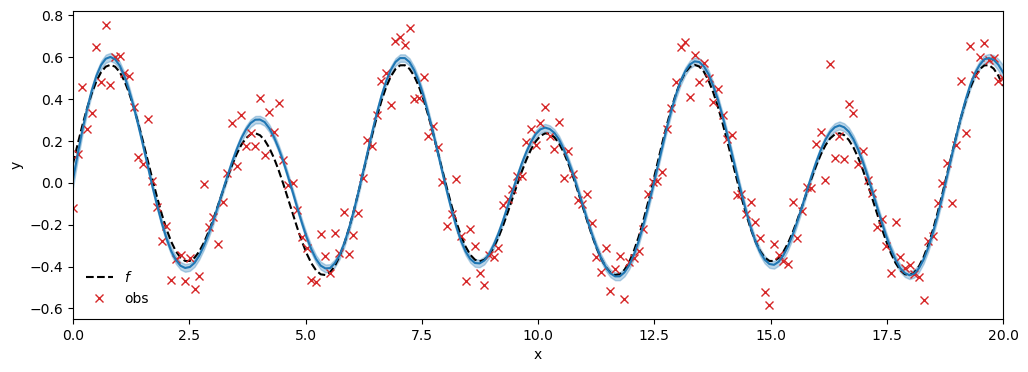

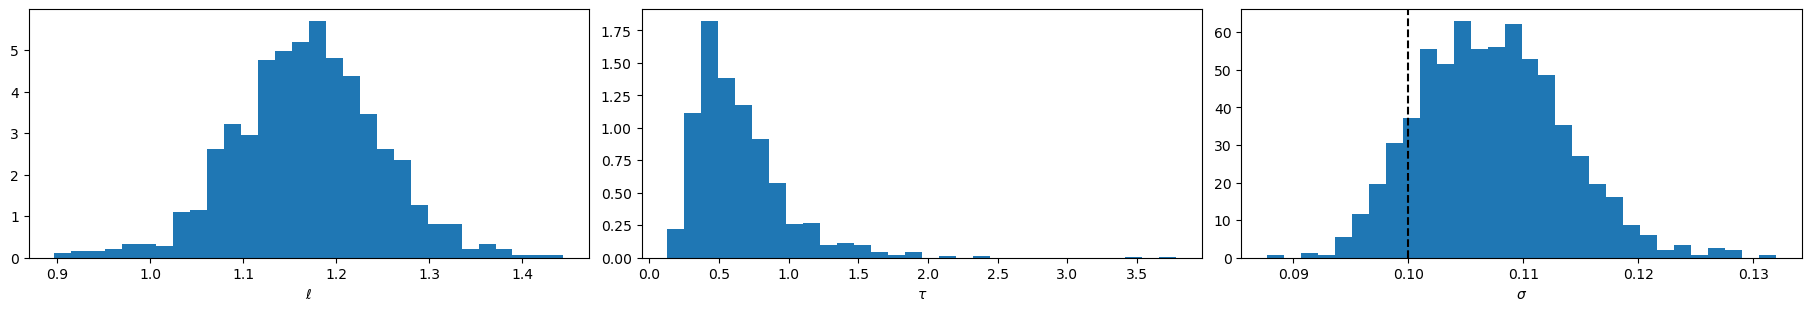

In [7]:
f_mean = jnp.mean(final_state.particles['gp'], axis=0)
f_std = jnp.std(final_state.particles['gp'], axis=0)

plt.figure(figsize=(12, 4))
plt.plot(jnp.squeeze(x), f_true, 'k', label=r'$f$', ls='--')
plt.plot(jnp.squeeze(x), y, 'x', label='obs', color='tab:red')
plt.plot(jnp.squeeze(x), f_mean, color='tab:blue')
plt.fill_between(jnp.squeeze(x), f_mean - 0.5*f_std, f_mean + 0.5*f_std, color='tab:blue', alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 20.])
plt.legend(frameon=False);

_, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(18, 3))

axes[0].hist(final_state.particles['lengthscale'], bins=30, density=True)
axes[0].set_xlabel(r'$\ell$');
axes[1].hist(final_state.particles['variance'], bins=30, density=True)
axes[1].set_xlabel(r'$\tau$');
axes[2].hist(final_state.particles['obs_noise'], bins=30, density=True)
axes[2].axvline(x=sigma, ls='--', color='k')
axes[2].set_xlabel(r'$\sigma$');

## Gaussian process classification

For a classification task (in this case, binary), we have a Bernoulli likelihood and hence conjugacy does not apply. When explicitly sampling the GP that does not matter, as shown in the implementation below.


In [8]:
from sklearn.datasets import make_moons

noise = 0.2
num_obs = 200

X, Y = make_moons(noise=noise, n_samples=num_obs)
n, p = X.shape

In [9]:
def logit_link_fn(f):
    return dict(probs=jax.nn.sigmoid(f))

#
cov_fn = jk.RBF().cross_covariance
GPC = Model('Gaussian process classification')
lengthscale = GPC.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance = GPC.add_node(name='variance', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
x_node = GPC.add_node(name='input', observations=X)
f_node = GPC.add_node(name='f', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=cov_fn), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=variance))
y_node = GPC.add_node(name='y', distribution=dx.Bernoulli, observations=Y, parents=dict(f=f_node), link_fn=logit_link_fn)

In [ ]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(lengthscale=blackjax.normal_random_walk,
                variance=blackjax.normal_random_walk,
                f=blackjax.elliptical_slice)

step_fn_params = dict(lengthscale=dict(sigma=0.03),
                      variance=dict(sigma=3.0),
                      f=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(GPC, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

engine = SMCInference(model=GPC, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps, return_diagnostics=True)
result = engine.run(subkey)

final_info = result['final_info']
lml = result['lml']
n_iter = result['n_iter']
final_state = result['final_state']

for node in ['lengthscale', 'variance']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

Acceptance rate for lengthscale: 0.207
Acceptance rate for variance: 0.669
CPU times: user 4min 47s, sys: 702 ms, total: 4min 47s
Wall time: 4min 42s


In [11]:
def predictive_gp_wrapper(key: Array, gp_node: Node, particle: Array, x_pred: Array):    
    gp_dist = gp_node.get_distribution(particle)
    f_pred = gp_dist.sample_predictive_batched(key, x_pred=x_pred, f=particle['f'], num_batches=20)
    return f_pred

#
num_x, num_y = 40, 40
xv, yv = jnp.meshgrid(jnp.linspace(-2.0, 3.0, num=num_x), jnp.linspace(-2.0, 3.0, num=num_y))
xpred = jnp.vstack([xv.flatten(), yv.flatten()]).T
keys = jrnd.split(key, num_particles)
particle_in_axes = jax.tree_util.tree_map(lambda l: 0, final_state.particles)
f_pred = jax.vmap(predictive_gp_wrapper, in_axes=(0, None, particle_in_axes, None))(keys, GPC.nodes['f'], final_state.particles, xpred)

p_pred = jax.nn.sigmoid(f_pred.reshape(-1, num_x, num_y))

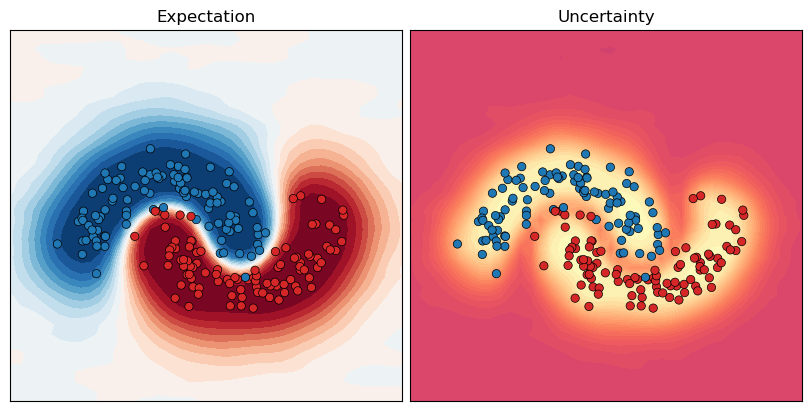

In [12]:
def plot_double_moon_fit(xgrid, logit, levels=20):
    xv, yv = xgrid
    data_colors = ["tab:red" if yn==1 else "tab:blue" for yn in Y]
    
    _, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True, figsize=(8, 4))
    
    mu = jnp.mean(logit, axis=0)
    sigma = jnp.std(logit, axis=0)
    axes[0].contourf(xv, yv, mu, zorder=0, cmap="RdBu_r", vmin=0.0, vmax=1.0, levels=levels)
    axes[1].contourf(xv, yv, sigma, zorder=0, cmap="magma_r", vmin=0.0, vmax=1.0, levels=levels)

    axes[0].set_title('Expectation')
    axes[1].set_title('Uncertainty')

    for ax in axes.flatten():
        ax.scatter(*X.T, c=data_colors, zorder=1, linewidths=0.5, edgecolors='k')
        ax.set_xticks([])
        ax.set_yticks([])

#

plot_double_moon_fit((xv, yv), p_pred)

The shapes of the expectation and the uncertainty nicely follow the data distributions. 

# The heteroskedastic GP

In the heteroskedastic GP, the observation noise itself is assumed to depend on the input. We model both the mean and the observation noise using Gaussian processes. Since the observation noise is the standard deviation of the Gaussian distribution, it cannot be negative so we use an exponential transformation as link function.

Text(0, 0.5, '$\\sigma$')

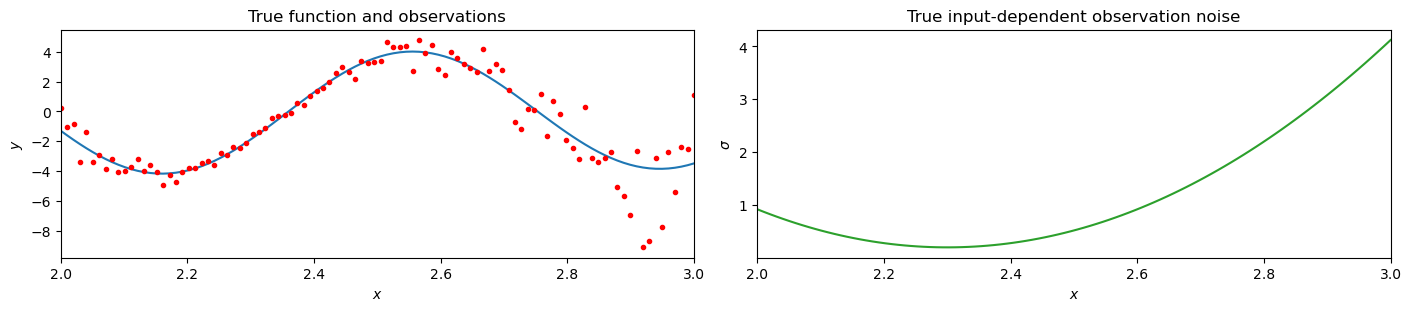

In [13]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

n = 100
x = jnp.linspace(2, 3, n)[:, jnp.newaxis]

f_true = 4*jnp.sin(8*x) + 0.1*jnp.cos(2*x-0.4) + 0.1*jnp.sin(5*x)
g_true = 8*(x-2.3)**2+0.2

y = f_true.squeeze() + g_true.squeeze()*jrnd.normal(subkey, shape=(n,))

_, axes = plt.subplots(nrows=1, ncols=2, sharex=True, constrained_layout=True, figsize=(14, 3))

axes[0].plot(x, f_true)
axes[0].plot(x, y, '.', color='r')
axes[0].set_title('True function and observations')
axes[1].plot(x, g_true, color='tab:green')
axes[1].set_title('True input-dependent observation noise')
for ax in axes:
    ax.set_xlabel(r'$x$')
    ax.set_xlim([2., 3.])
axes[0].set_ylabel(r'$y$')
axes[1].set_ylabel(r'$\sigma$')

In [14]:
HSGP = Model('Heteroskedastic Gaussian process')
x_node = HSGP.add_node(name='input', observations=x)

lengthscale_f = HSGP.add_node(name='lengthscale_f', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance_f = HSGP.add_node(name='variance_f', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
lengthscale_g = HSGP.add_node(name='lengthscale_g', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance_g = HSGP.add_node(name='variance_g', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))

cov_fn = jk.RBF().cross_covariance
g = HSGP.add_node(name='g', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=cov_fn), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale_g, 
                                    variance=variance_g))
f = HSGP.add_node(name='f', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=cov_fn), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale_f, 
                                    variance=variance_f))
y_node = HSGP.add_node(name='y', distribution=dx.Normal, observations=y, parents=dict(loc=f, scale=g), link_fn=lambda loc, scale: dict(loc=loc, scale=jnp.exp(scale)))

HSGP.print_gibbs()

Gibbs structure:
lengthscale_f       : p(f | lengthscale_f, variance_f, input) p(lengthscale_f)
variance_f          : p(f | input, variance_f, lengthscale_f) p(variance_f)
f                   : p(y | g, f) p(f | variance_f, input, lengthscale_f)
lengthscale_g       : p(g | variance_g, lengthscale_g, input) p(lengthscale_g)
variance_g          : p(g | variance_g, lengthscale_g, input) p(variance_g)
g                   : p(y | g, f) p(g | variance_g, lengthscale_g, input)


In [ ]:
%%time

num_mcmc_steps = 300
num_particles = 1_000

step_fns = dict(lengthscale_f=blackjax.normal_random_walk,
                variance_f=blackjax.normal_random_walk,
                lengthscale_g=blackjax.normal_random_walk,
                variance_g=blackjax.normal_random_walk,
                f=blackjax.elliptical_slice,
                g=blackjax.elliptical_slice)

step_fn_params = dict(lengthscale_f=dict(sigma=0.005),
                      variance_f=dict(sigma=1.0),
                      lengthscale_g=dict(sigma=0.01),
                      variance_g=dict(sigma=0.7),
                      f=dict(implied_mvn_prior=True, name='elliptical_slice'),
                      g=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(HSGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

engine = SMCInference(model=HSGP, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps, return_diagnostics=True)
result = engine.run(subkey)

final_info = result['final_info']
hsgp_lml = result['lml']
n_iter = result['n_iter']
final_state = result['final_state']

for gp in ['f', 'g']:
    for theta in [f'lengthscale_{gp}', f'variance_{gp}']:
        print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for lengthscale_f: 0.498
Acceptance rate for variance_f: 0.773
Acceptance rate for lengthscale_g: 0.500
Acceptance rate for variance_g: 0.432
CPU times: user 14min 6s, sys: 1.6 s, total: 14min 7s
Wall time: 13min 59s


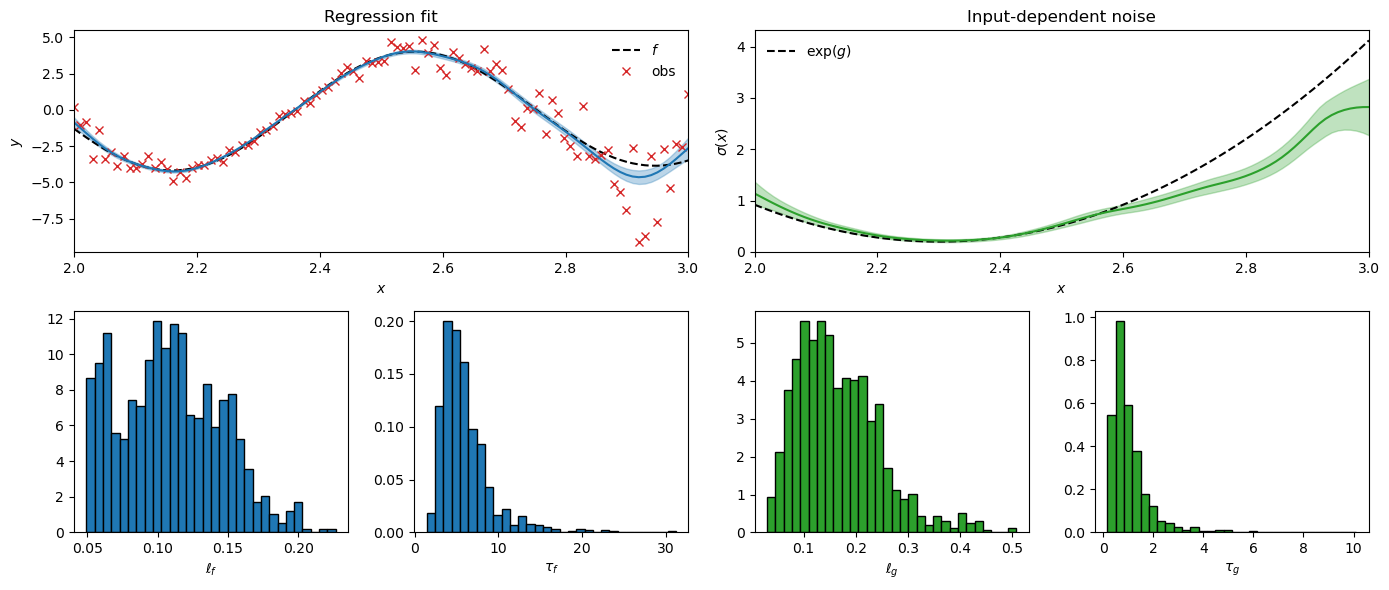

In [16]:
import matplotlib.gridspec as gridspec

f_mean = jnp.mean(final_state.particles['f'], axis=0)
f_std = jnp.std(final_state.particles['f'], axis=0)
g_transformed = jax.vmap(lambda x: jnp.exp(x), in_axes=0)(final_state.particles['g'])
g_mean = jnp.mean(g_transformed, axis=0)
g_std = jnp.std(g_transformed, axis=0)
nbins = 30

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_title('Regression fit')

ax1.plot(jnp.squeeze(x), f_true, 'k', label=r'$f$', ls='--')
ax1.plot(jnp.squeeze(x), y, 'x', label='obs', color='tab:red')
ax1.plot(jnp.squeeze(x), f_mean, color='tab:blue')
ax1.fill_between(jnp.squeeze(x), f_mean - 0.5*f_std, f_mean + 0.5*f_std, color='tab:blue', alpha=0.3)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
ax1.set_xlim([2., 3.])
ax1.legend(frameon=False);

ax2 = fig.add_subplot(gs[0, 2:4])
ax2.set_title('Input-dependent noise')

ax2.plot(jnp.squeeze(x), g_true, 'k', label=r'$\text{exp}(g)$', ls='--')
ax2.plot(jnp.squeeze(x), g_mean, color='tab:green')
ax2.fill_between(jnp.squeeze(x), g_mean - 0.5*g_std, g_mean + 0.5*g_std, color='tab:green', alpha=0.3)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\sigma(x)$')
ax2.set_xlim([2., 3.])
ax2.legend(frameon=False);

ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(final_state.particles['lengthscale_f'].flatten(), bins=nbins, density=True, edgecolor='k', facecolor='tab:blue')
ax3.set_xlabel(r'$\ell_f$')

ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(final_state.particles['variance_f'].flatten(), bins=nbins, density=True, edgecolor='k', facecolor='tab:blue')
ax4.set_xlabel(r'$\tau_f$')

ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(final_state.particles['lengthscale_g'].flatten(), bins=nbins, density=True, edgecolor='k', facecolor='tab:green')
ax5.set_xlabel(r'$\ell_g$')

ax6 = fig.add_subplot(gs[1, 3])
ax6.hist(final_state.particles['variance_g'].flatten(), bins=nbins, density=True, edgecolor='k', facecolor='tab:green')
ax6.set_xlabel(r'$\tau_g$')

plt.tight_layout()
plt.show()

Let's compare with a generic GP.

In [ ]:
%%time
cov_fn = jk.RBF().cross_covariance

LatentGP = Model('Latent Gaussian process')
lengthscale = LatentGP.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance = LatentGP.add_node(name='variance', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
obs_noise = LatentGP.add_node(name='obs_noise', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
x_node = LatentGP.add_node(name='input', observations=x)
gp = LatentGP.add_node(name='gp', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=cov_fn), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=variance))
y_node = LatentGP.add_node(name='y', distribution=dx.Normal, observations=y, parents=dict(loc=gp, scale=obs_noise))


num_mcmc_steps = 300
num_particles = 1_000

step_fns = dict(lengthscale=blackjax.normal_random_walk,
                variance=blackjax.normal_random_walk,
                obs_noise=blackjax.normal_random_walk,
                gp=blackjax.elliptical_slice)

step_fn_params = dict(lengthscale=dict(sigma=0.01),
                      variance=dict(sigma=1.0),
                      obs_noise=dict(sigma=0.1),
                      gp=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(LatentGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

engine = SMCInference(model=LatentGP, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps, return_diagnostics=True)
result = engine.run(subkey)

final_info = result['final_info']
lgp_lml = result['lml']
n_iter = result['n_iter']
final_state = result['final_state']

for node in ['lengthscale', 'variance', 'obs_noise']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

Acceptance rate for lengthscale: 0.149
Acceptance rate for variance: 0.769
Acceptance rate for obs_noise: 0.645
CPU times: user 4min 48s, sys: 690 ms, total: 4min 49s
Wall time: 4min 44s


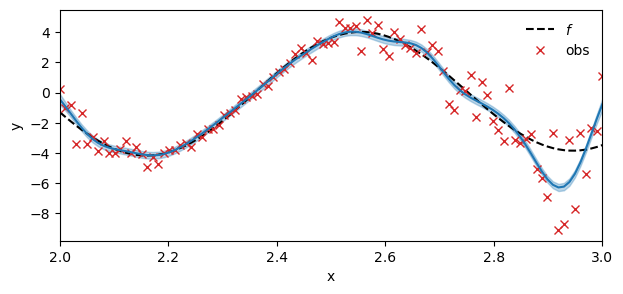

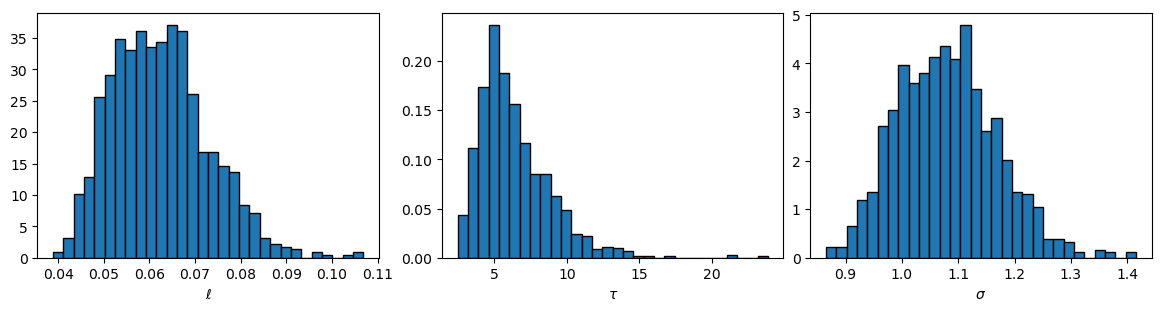

In [18]:
f_mean = jnp.mean(final_state.particles['gp'], axis=0)
f_std = jnp.std(final_state.particles['gp'], axis=0)

plt.figure(figsize=(7, 3))
plt.plot(jnp.squeeze(x), f_true, 'k', label=r'$f$', ls='--')
plt.plot(jnp.squeeze(x), y, 'x', label='obs', color='tab:red')
plt.plot(jnp.squeeze(x), f_mean, color='tab:blue')
plt.fill_between(jnp.squeeze(x), f_mean - 0.5*f_std, f_mean + 0.5*f_std, color='tab:blue', alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([2., 3.])
plt.legend(frameon=False);

_, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(11.5, 3))

axes[0].hist(final_state.particles['lengthscale'], bins=30, density=True, edgecolor='k')
axes[0].set_xlabel(r'$\ell$');
axes[1].hist(final_state.particles['variance'], bins=30, density=True, edgecolor='k')
axes[1].set_xlabel(r'$\tau$');
axes[2].hist(final_state.particles['obs_noise'], bins=30, density=True, edgecolor='k')
axes[2].set_xlabel(r'$\sigma$');

Compare marginal likelihoods: is the additional complexity of the HSGP needed here?

In [19]:
print(f'Log marginal likelihood LGP: {lgp_lml:0.3f}')
print(f'Log marginal likelihood HSGP: {hsgp_lml:0.3f}')

Log marginal likelihood LGP: -184.916
Log marginal likelihood HSGP: -148.637


Apparently so, despite the regression fit being very similar!

## Composite covariance functions

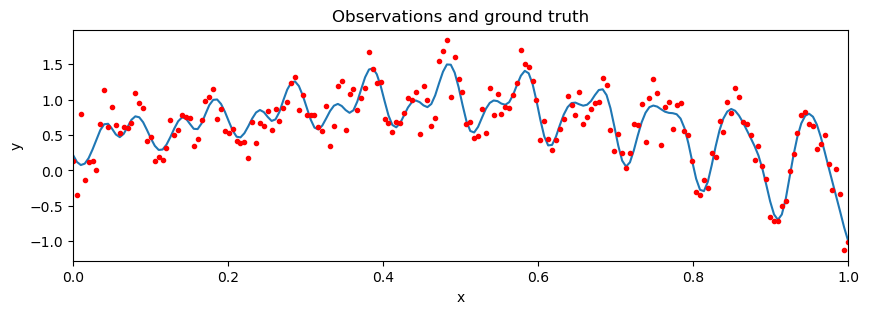

In [20]:
def gp_sample(key, K, mu=None, num_samples=1):
    n = K.shape[0]
    if mu is None:
        mu = jnp.zeros((n, num_samples))
    elif jnp.ndim(mu) == 1:
        mu = jnp.tile(mu, reps=(num_samples, 1)).T

    L = jnp.linalg.cholesky(K)
    z = jrnd.normal(key, shape=(n, num_samples))
    f = jnp.dot(L, z) + mu
    return f.flatten()

#



key = jrnd.PRNGKey(42)
key, key_f, key_y = jrnd.split(key, 3)

n = 200
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

kernel = jk.RBF() * jk.Periodic()
cov_fn = kernel.cross_covariance
K = cov_fn(params=[dict(lengthscale=0.5, variance=20.), dict(period=0.1, lengthscale=1., variance=0.1)],
                            x=x, y=x) + 1e-6*jnp.eye(n)

mu = jnp.zeros((n, ))
f_true = gp_sample(key_f, K, mu=mu, num_samples=1)
y = f_true + 0.2*jrnd.normal(key_y, shape=(n,))

plt.figure(figsize=(10, 3))
plt.plot(x, f_true, color='tab:blue')
plt.plot(x, y, '.', color='r')
plt.xlim([0., 1.])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observations and ground truth');

In [21]:
def compound_link_fn(input, lengthscale_rbf, variance_rbf, period_per, lengthscale_per, variance_per):
    return dict(input=input, params=[dict(lengthscale=lengthscale_rbf, variance=variance_rbf),
                                     dict(period=period_per, lengthscale=lengthscale_per, variance=variance_per)])

#
compound_kernel = jk.RBF() * jk.Periodic()  # parameter structure is a list of dicts; see recursive structure
compound_cov_fn = compound_kernel.cross_covariance

CKGP = Model('Compound Kernel Gaussian process')
lengthscale_rbf = CKGP.add_node(name='lengthscale_rbf', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance_rbf = CKGP.add_node(name='variance_rbf', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))

lengthscale_per = CKGP.add_node(name='lengthscale_per', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance_per = CKGP.add_node(name='variance_per', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
period_per = CKGP.add_node(name='period_per', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))

obs_noise = CKGP.add_node(name='obs_noise', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
x_node = CKGP.add_node(name='input', observations=x)
gp = CKGP.add_node(name='gp', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=compound_cov_fn), 
                       parents=dict(input=x_node, 
                                    lengthscale_rbf=lengthscale_rbf, 
                                    variance_rbf=variance_rbf,
                                    period_per=period_per,
                                    lengthscale_per=lengthscale_per,
                                    variance_per=variance_per),
                        link_fn=compound_link_fn)
y_node = CKGP.add_node(name='y', distribution=dx.Normal, observations=y, parents=dict(loc=gp, scale=obs_noise))

CKGP.print_gibbs()

Gibbs structure:
lengthscale_rbf     : p(gp | lengthscale_rbf, variance_rbf, variance_per, input, period_per, lengthscale_per) p(lengthscale_rbf)
variance_rbf        : p(gp | lengthscale_rbf, variance_rbf, variance_per, input, period_per, lengthscale_per) p(variance_rbf)
period_per          : p(gp | lengthscale_rbf, variance_rbf, variance_per, input, period_per, lengthscale_per) p(period_per)
lengthscale_per     : p(gp | lengthscale_rbf, variance_rbf, variance_per, input, period_per, lengthscale_per) p(lengthscale_per)
variance_per        : p(gp | lengthscale_rbf, variance_rbf, variance_per, input, period_per, lengthscale_per) p(variance_per)
gp                  : p(y | obs_noise, gp) p(gp | lengthscale_rbf, variance_rbf, variance_per, input, period_per, lengthscale_per)
obs_noise           : p(y | obs_noise, gp) p(obs_noise)


Draw samples from prior

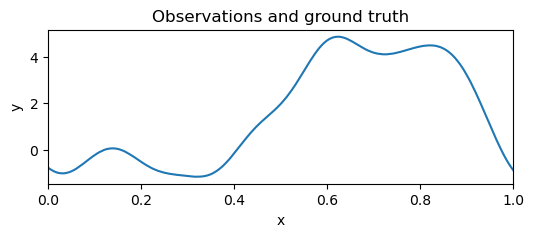

In [28]:
key, subkey = jrnd.split(key)

pp = CKGP.sample_prior(subkey)
plt.figure(figsize=(6, 2))
plt.plot(x, pp['gp'], color='tab:blue')
plt.xlim([0., 1.])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observations and ground truth');

In [ ]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(lengthscale_rbf=blackjax.normal_random_walk,
                variance_rbf=blackjax.normal_random_walk,
                lengthscale_per=blackjax.normal_random_walk,
                variance_per=blackjax.normal_random_walk,
                period_per=blackjax.normal_random_walk,
                obs_noise=blackjax.normal_random_walk,
                gp=blackjax.elliptical_slice)

step_fn_params = dict(lengthscale_rbf=dict(sigma=0.04),
                      variance_rbf=dict(sigma=0.1),
                      lengthscale_per=dict(sigma=0.04),
                      variance_per=dict(sigma=0.1),
                      period_per=dict(sigma=0.01),
                      obs_noise=dict(sigma=0.01),
                      gp=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(CKGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

engine = SMCInference(model=CKGP, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps, return_diagnostics=True)
result = engine.run(subkey)

final_info = result['final_info']
lml = result['lml']
n_iter = result['n_iter']
final_state = result['final_state']


for node in ['lengthscale_rbf', 'variance_rbf', 'lengthscale_per', 'variance_per', 'period_per', 'obs_noise']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

print('SMC adaptation iterations:', n_iter)
print('Log marginal likelihood:', lml)

Acceptance rate for lengthscale_rbf: 0.937
Acceptance rate for variance_rbf: 0.789
Acceptance rate for lengthscale_per: 0.088
Acceptance rate for variance_per: 0.813
Acceptance rate for period_per: 0.895
Acceptance rate for obs_noise: 0.780
SMC adaptation iterations: 40
Log marginal likelihood: -70.94961990661677
CPU times: user 20min 42s, sys: 1.48 s, total: 20min 43s
Wall time: 20min 34s


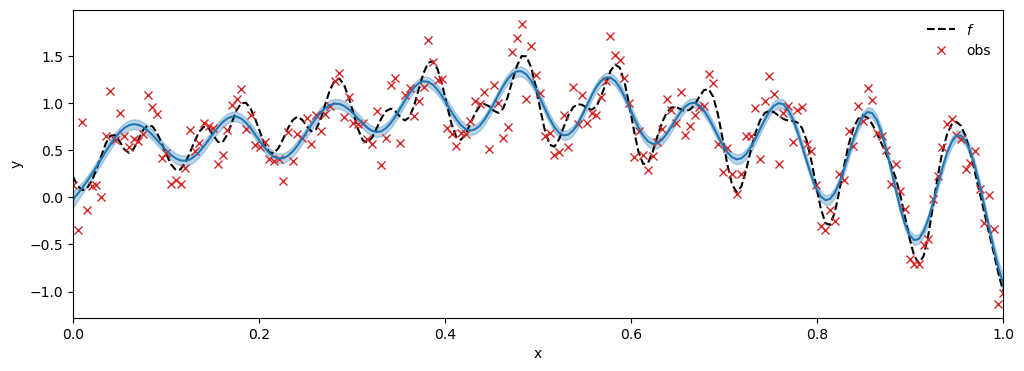

In [24]:
f_mean = jnp.mean(final_state.particles['gp'], axis=0)
f_std = jnp.std(final_state.particles['gp'], axis=0)

plt.figure(figsize=(12, 4))
plt.plot(jnp.squeeze(x), f_true, 'k', label=r'$f$', ls='--')
plt.plot(jnp.squeeze(x), y, 'x', label='obs', color='tab:red')
plt.plot(jnp.squeeze(x), f_mean, color='tab:blue')
plt.fill_between(jnp.squeeze(x), f_mean - 0.5*f_std, f_mean + 0.5*f_std, color='tab:blue', alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend(frameon=False);

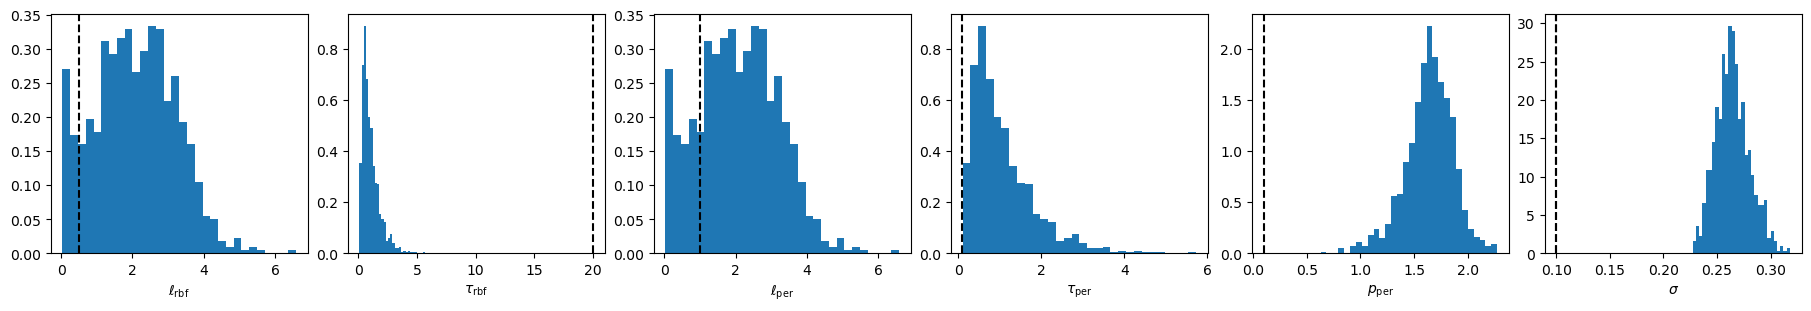

In [25]:
_, axes = plt.subplots(nrows=1, ncols=6, constrained_layout=True, figsize=(18, 3))

K = kernel.cross_covariance(params=[dict(lengthscale=0.5, variance=20.), dict(period=0.1, lengthscale=1., variance=0.1)],
                            x=x, y=x) + 1e-6*jnp.eye(n)

axes[0].hist(final_state.particles['lengthscale_rbf'], bins=30, density=True)
axes[0].set_xlabel(r'$\ell_{\text{rbf}}$');
axes[0].axvline(x=0.5, color='k', ls='--')
axes[1].hist(final_state.particles['variance_rbf'], bins=30, density=True)
axes[1].set_xlabel(r'$\tau_{\text{rbf}}$');
axes[1].axvline(x=20.0, color='k', ls='--')
axes[2].hist(final_state.particles['lengthscale_rbf'], bins=30, density=True)
axes[2].set_xlabel(r'$\ell_{\text{per}}$');
axes[2].axvline(x=1., color='k', ls='--')
axes[3].hist(final_state.particles['variance_rbf'], bins=30, density=True)
axes[3].set_xlabel(r'$\tau_{\text{per}}$')
axes[3].axvline(x=0.1, color='k', ls='--')
axes[4].hist(final_state.particles['period_per'], bins=30, density=True)
axes[4].set_xlabel(r'$p_{\text{per}}$')
axes[4].axvline(x=0.1, color='k', ls='--')
axes[5].hist(final_state.particles['obs_noise'], bins=30, density=True)
axes[5].axvline(x=sigma, ls='--', color='k')
axes[5].set_xlabel(r'$\sigma$')
axes[5].axvline(x=0.1, color='k', ls='--')

Not enough data to correctly learn all parameters, but the fit is decent.